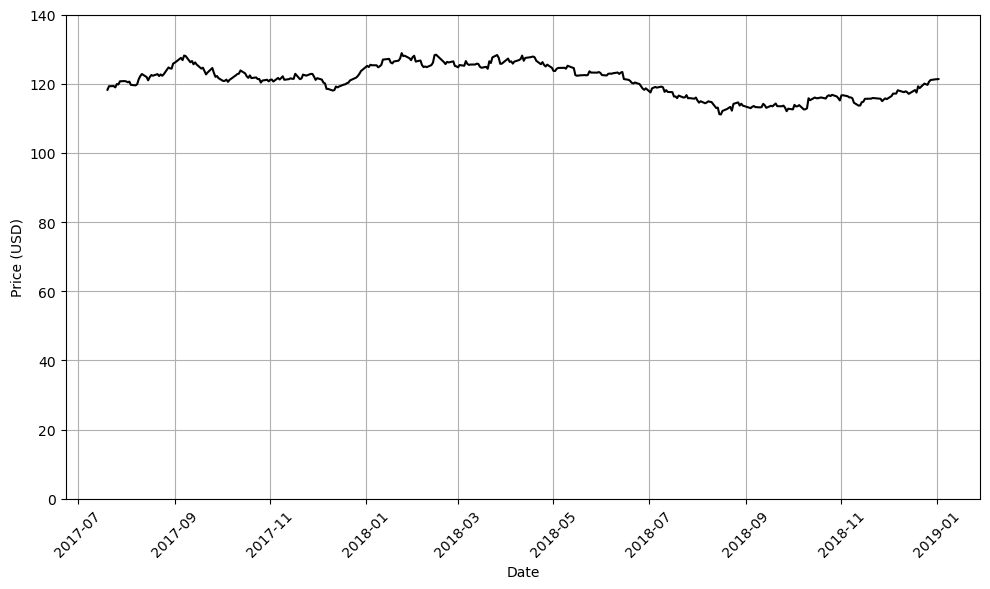

In [22]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Draw the gold price trend plot
gold_data = pd.read_excel('goldprice.xlsx')
# Plot the gold closing prices over time
plt.figure(figsize=(10, 6))
plt.plot(gold_data['date'], gold_data['gold close'], label='Gold Close Price', color='black')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.yticks(ticks=range(0, 160, 20))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('goldprice.png')

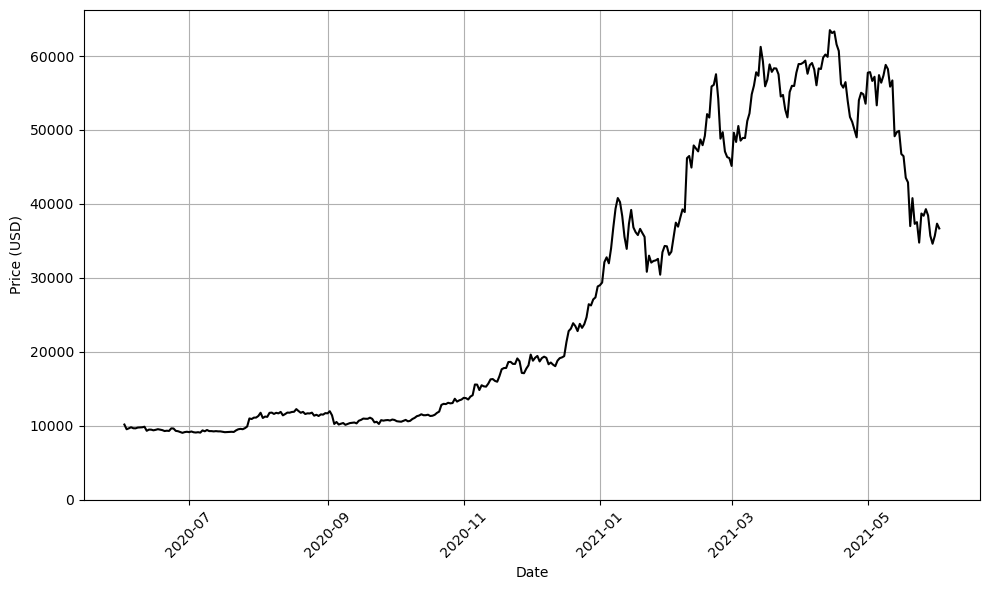

In [24]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Draw the Bitcoin price trend plot
bit_data = pd.read_excel('bitcoinprice.xlsx')
bit_data['date'] = pd.to_datetime(bit_data['date'])
# Plot the Bitcoin closing prices over time
plt.figure(figsize=(10, 6))
plt.plot(bit_data['date'], bit_data['Close'], label='Bitcoin Close Price', color='black')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.yticks(ticks=range(0, 70000, 10000))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Bitcoinprice.png')

Epoch [10/300], Loss: 0.0974
Epoch [20/300], Loss: 0.0588
Epoch [30/300], Loss: 0.0475
Epoch [40/300], Loss: 0.0428
Epoch [50/300], Loss: 0.0415
Epoch [60/300], Loss: 0.0385
Epoch [70/300], Loss: 0.0330
Epoch [80/300], Loss: 0.0320
Epoch [90/300], Loss: 0.0309
Epoch [100/300], Loss: 0.0311
Epoch [110/300], Loss: 0.0295
Epoch [120/300], Loss: 0.0293
Epoch [130/300], Loss: 0.0301
Epoch [140/300], Loss: 0.0285
Epoch [150/300], Loss: 0.0290
Epoch [160/300], Loss: 0.0282
Epoch [170/300], Loss: 0.0291
Epoch [180/300], Loss: 0.0286
Epoch [190/300], Loss: 0.0286
Epoch [200/300], Loss: 0.0271
Epoch [210/300], Loss: 0.0274
Epoch [220/300], Loss: 0.0262
Epoch [230/300], Loss: 0.0254
Epoch [240/300], Loss: 0.0239
Epoch [250/300], Loss: 0.0246
Epoch [260/300], Loss: 0.0276
Epoch [270/300], Loss: 0.0226
Epoch [280/300], Loss: 0.0230
Epoch [290/300], Loss: 0.0219
Epoch [300/300], Loss: 0.0253
Mean Absolute Percentage Error (MAPE): 0.65%


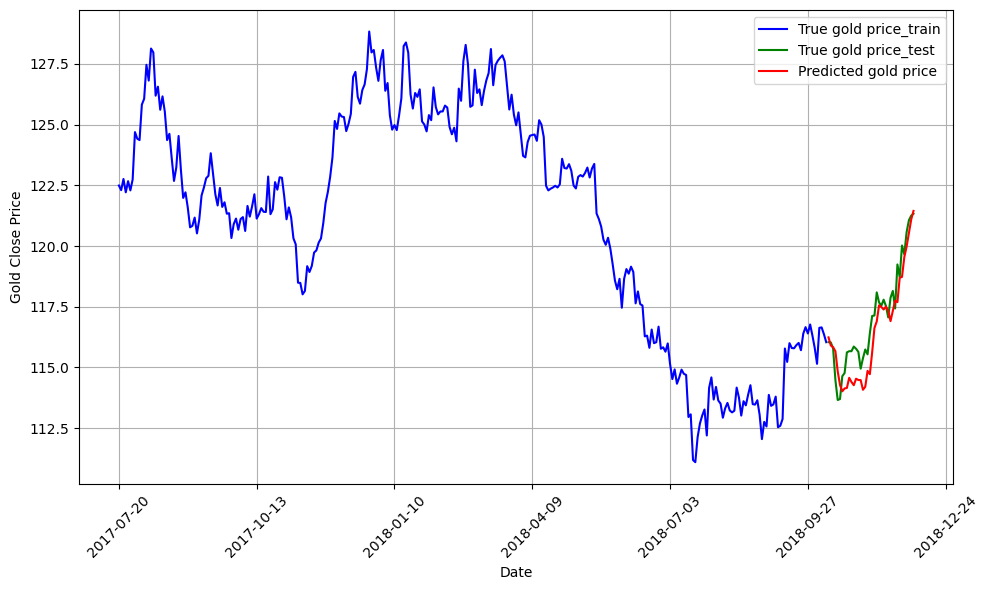

In [26]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Gold price prediction model
# This model was adapated from https://github.com/yangwohenmai/LSTM/tree/master/stock_predict, I used chatgpt for some help 
# Data preposseing
data = pd.read_excel('goldprice.xlsx')  
data_cleaned = data.dropna()  
dates = pd.to_datetime(data_cleaned['date']).dt.strftime('%Y-%m-%d').values #delete the hour, minute and second
features = ['gold open', 'gold high', 'gold low', 'gold close', 'gold volume']
data_values = data_cleaned[features].values

# Normalize data
mean = np.mean(data_values, axis=0)
std = np.std(data_values, axis=0)
normalized_data = (data_values - mean) / std

# Parameters
time_step = 20  
train_ratio = 0.9  # Train/test split ratio

# Prepare sequences
def create_sequences(data, time_step):
    x, y = [], []
    for i in range(len(data) - time_step):
        x.append(data[i:i + time_step, :-1]) 
        y.append(data[i + time_step, -2])  # Use the 'gold close' column as target
    return np.array(x), np.array(y)

# Split Train/test set
train_size = int(len(normalized_data) * train_ratio)
train_data = normalized_data[:train_size]
test_data = normalized_data[train_size - time_step-1:]  
train_dates = dates[:train_size]  
test_dates = dates[train_size - time_step:]
train_x, train_y = create_sequences(train_data, time_step)
test_x, test_y = create_sequences(test_data, time_step)

# Turn the train set data into pytorch tensor
train_x_tensor = torch.tensor(train_x, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32).unsqueeze(-1)
test_x_tensor = torch.tensor(test_x, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).unsqueeze(-1)

# Bulid model
class GoldPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(GoldPriceLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)     
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) 
        return out

# Hyperparameters
input_size = train_x.shape[2]  # Number of features
hidden_size = 100  # Hidden layer size
num_layers = 3  # Number of layers
output_size = 1
dropout = 0.2  # Add dropout to prevent overfitting
learning_rate = 0.001
batch_size = 64  # Use batch training
num_epochs = 300 

# Model loss fuction and optimizer
model = GoldPriceLSTM(input_size, hidden_size, num_layers, output_size, dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training model
train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_y_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # 梯度裁剪
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

# Use model to make prediction
model.eval()
with torch.no_grad():
    train_predict = model(train_x_tensor).squeeze().numpy()
    test_predict = model(test_x_tensor).squeeze().numpy()

# Denormalize predictions and true values
train_predict_denorm = train_predict * std[-2] + mean[-2]
test_predict_denorm = test_predict * std[-2] + mean[-2]
train_y_denorm = train_y * std[-2] + mean[-2]
test_y_denorm = test_y * std[-2] + mean[-2]

# Visualizatioon

plt.figure(figsize=(10, 6))
plt.plot(range(len(train_y_denorm)), train_y_denorm, label='True gold price_train', color='blue')
plt.plot(range(len(train_y_denorm), len(train_y_denorm) + len(test_y_denorm)), test_y_denorm, label='True gold price_test', color='green')
plt.plot(range(len(train_y_denorm), len(train_y_denorm) + len(test_predict_denorm)), test_predict_denorm, label='Predicted gold price', color='red')
plt.xticks(ticks=range(0, len(dates), 60), labels=dates[::60], rotation=45)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Gold Close Price')
plt.grid(True)
plt.tight_layout()
plt.savefig('gold_predict.png')

#Compute the MAPE
mape = np.mean(np.abs((test_y_denorm - test_predict_denorm) / test_y_denorm)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Epoch [10/300], Loss: 0.0292
Epoch [20/300], Loss: 0.0197
Epoch [30/300], Loss: 0.0179
Epoch [40/300], Loss: 0.0157
Epoch [50/300], Loss: 0.0120
Epoch [60/300], Loss: 0.0126
Epoch [70/300], Loss: 0.0109
Epoch [80/300], Loss: 0.0097
Epoch [90/300], Loss: 0.0093
Epoch [100/300], Loss: 0.0088
Epoch [110/300], Loss: 0.0080
Epoch [120/300], Loss: 0.0079
Epoch [130/300], Loss: 0.0073
Epoch [140/300], Loss: 0.0076
Epoch [150/300], Loss: 0.0079
Epoch [160/300], Loss: 0.0081
Epoch [170/300], Loss: 0.0078
Epoch [180/300], Loss: 0.0081
Epoch [190/300], Loss: 0.0072
Epoch [200/300], Loss: 0.0079
Epoch [210/300], Loss: 0.0074
Epoch [220/300], Loss: 0.0070
Epoch [230/300], Loss: 0.0064
Epoch [240/300], Loss: 0.0069
Epoch [250/300], Loss: 0.0064
Epoch [260/300], Loss: 0.0063
Epoch [270/300], Loss: 0.0063
Epoch [280/300], Loss: 0.0057
Epoch [290/300], Loss: 0.0051
Epoch [300/300], Loss: 0.0064
Mean Absolute Percentage Error (MAPE): 5.09%


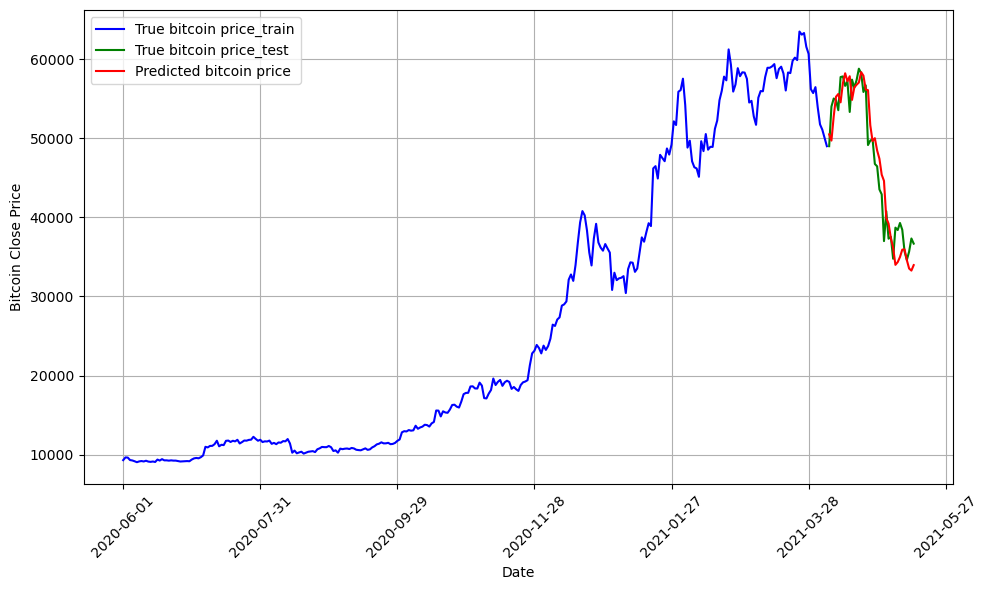

In [28]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Bitcoin price prediction model
# Data preposseing
data = pd.read_excel('bitcoinprice.xlsx')  
data_cleaned = data.dropna()  
dates = pd.to_datetime(data_cleaned['date']).dt.strftime('%Y-%m-%d').values #delete the hour, minute and second
features = ['High', 'Low', 'Open', 'Close', 'Volume']
data_values = data_cleaned[features].values
# Normalize data
mean = np.mean(data_values, axis=0)
std = np.std(data_values, axis=0)
normalized_data = (data_values - mean) / std

# Parameters
time_step = 20  
train_ratio = 0.9  # Train/test split ratio

# Prepare sequences
def create_sequences(data, time_step):
    x, y = [], []
    for i in range(len(data) - time_step):
        x.append(data[i:i + time_step, :-1])  # Use all columns except the last as features
        y.append(data[i + time_step, -2])  # Use the 'gold close' column as target
    return np.array(x), np.array(y)

# Split Train/test set
train_size = int(len(normalized_data) * train_ratio)
train_data = normalized_data[:train_size]
test_data = normalized_data[train_size - time_step-1:]  # 从训练集末尾部分重叠
train_x, train_y = create_sequences(train_data, time_step)
test_x, test_y = create_sequences(test_data, time_step)

# Turn the train set data into pytorch tensor
train_x_tensor = torch.tensor(train_x, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32).unsqueeze(-1)
test_x_tensor = torch.tensor(test_x, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).unsqueeze(-1)

# Bulid model
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BitcoinPriceLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last time step's output
        return out

# Hyperparameters
input_size = train_x.shape[2]  # Number of features
hidden_size = 100  # Increase hidden size for better representation
num_layers = 3  # Add more layers to improve capacity
output_size = 1
dropout = 0.2  # Add dropout to prevent overfitting
learning_rate = 0.001
batch_size = 64  # Use batch training
num_epochs = 300  # Increase training epochs

# # Model loss fuction and optimizer
model = BitcoinPriceLSTM(input_size, hidden_size, num_layers, output_size, dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training model
train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_y_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # 梯度裁剪
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

# Use model to make prediction
model.eval()
with torch.no_grad():
    train_predict = model(train_x_tensor).squeeze().numpy()
    test_predict = model(test_x_tensor).squeeze().numpy()

# Denormalize predictions and true values
train_predict_denorm = train_predict * std[-2] + mean[-2]
test_predict_denorm = test_predict * std[-2] + mean[-2]
train_y_denorm = train_y * std[-2] + mean[-2]
test_y_denorm = test_y * std[-2] + mean[-2]

# Visualizatioon

plt.figure(figsize=(10, 6))
plt.plot(range(len(train_y_denorm)), train_y_denorm, label='True bitcoin price_train', color='blue')
plt.plot(range(len(train_y_denorm), len(train_y_denorm) + len(test_y_denorm)), test_y_denorm, label='True bitcoin price_test', color='green')
plt.plot(range(len(train_y_denorm), len(train_y_denorm) + len(test_predict_denorm)), test_predict_denorm, label='Predicted bitcoin price ', color='red')
plt.legend()
plt.xticks(ticks=range(0, len(dates), 60), labels=dates[::60], rotation=45)
plt.xlabel('Date')
plt.ylabel('Bitcoin Close Price')
plt.grid(True)
plt.tight_layout()
plt.savefig('bitcoin_predict.png')

#Compute the MAPE
mape = np.mean(np.abs((test_y_denorm - test_predict_denorm) / test_y_denorm)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")